# SVM

Use a standard SVM on 300d glove. Moved from glove.ipynb because I ran out of memory.

In [1]:
# Save these files so I don't have to do this again
import csv
def load_tokenized(path):
    with open(path, 'r') as f:
        reader = csv.reader(f, delimiter='|')
        sentences = []
        for row in reader:
            sentences.append(row)
        return sentences

q1_word_tokenized = load_tokenized('../data/train_q1.txt')
q2_word_tokenized = load_tokenized('../data/train_q2.txt')

In [2]:
is_duplicate = [int(x.strip()) for x in open('../data/train_is_duplicate.txt')]
is_duplicate[3355:3365]

[1, 0, 0, 0, 0, 1, 0, 1, 1, 1]

In [3]:
import numpy as np

def load_embeddings(filepath):
    embeddings = {}
    current_word = 0
    rows = []
    
    with open(filepath, "rb") as f:
        for line in f:
            line = line.decode("utf-8")
            elements = line.strip().split(' ', 1)
            word = elements[0]
            vector = [float(x) for x in elements[1].split(' ')]
            vector = np.array(vector)
            
            word_id = current_word
            current_word += 1
            embeddings[word] = word_id
            rows.append(vector)
    return embeddings, np.stack(rows, axis=0)

In [4]:
# What about 300d GloVe?
embeddings300, array300 = load_embeddings("../data/glove.6B.300d.txt")
print(array300.shape)

(400000, 300)


In [5]:
print(len(embeddings300))

400000


In [6]:
def get_paragraph_embedding(paragraph,
                            dictionary,
                            embeddings,
                            ignore_unknown=True,
                            unknown_embedding=None):
    '''Return a paragraph embedding as an average of its word embeddings.'''
    embedding_size = embeddings[dictionary['the'],:].shape[0] # autodetect
    paragraph_embedding = np.zeros(embedding_size)
    count_words = 0
    for word in paragraph:
        if word in dictionary:
            we = embeddings[dictionary[word]]
            paragraph_embedding += we
            count_words += 1
        elif not ignore_unknown:
            we = unknown_embedding
            paragraph_embedding += we
            count_words += 1
    if count_words == 0:
        paragraph_embedding = paragraph_embedding
    else:
        paragraph_embedding = paragraph_embedding / count_words
    return paragraph_embedding

In [7]:
q1_emb300 = []
q2_emb300 = []
for q1 in q1_word_tokenized:
    e = get_paragraph_embedding(q1, embeddings300, array300, ignore_unknown=True)
    q1_emb300.append(e)
for q2 in q2_word_tokenized:
    e = get_paragraph_embedding(q2, embeddings300, array300, ignore_unknown=True)
    q2_emb300.append(e)
q1_emb300 = np.stack(q1_emb300)
q2_emb300 = np.stack(q2_emb300)
print(q1_emb300.shape)
print(q2_emb300.shape)

(404288, 300)
(404288, 300)


In [8]:
q1q2 = np.concatenate([q1_emb300, q2_emb300], axis=1)
print(q1q2.shape)

(404288, 600)


Save memory:

In [9]:
del q1_emb300
del q2_emb300

# Checkpoint

At this point we have:
1. ``is_duplicate``: python list, values $\in \{0, 1\}$
1. ``q1q2``: np.Array, $\mathbb{R}^{400,000 \times 600}$

In [10]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer

rand = 33

X = q1q2
y = is_duplicate
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.4, random_state=rand)

nrm = Normalizer()
X_train = nrm.fit_transform(X_train)
X_valid = nrm.transform(X_valid)

In [11]:
# These numbers take a while to generate. Let's save them.
# It turns out they're pretty big, lol
np.savetxt('../data/train_X_train.txt', X_train)
np.savetxt('../data/train_X_valid.txt', X_valid)
np.savetxt('../data/train_y_train.txt', y_train)
np.savetxt('../data/train_y_valid.txt', y_valid)

In [12]:
# At this point we have a problem: too many examples!
# Idea #1: bagged SVM
indices = range(len(X_train))

In [69]:
from __future__ import print_function
bag_num = 100
examples_per_bag = 1000
models = []

C=1.0

for i in range(bag_num):
    print('Model:', i)
    np.random.shuffle(indices)
    i_bag = indices[:examples_per_bag]
    X_bag = X_train[i_bag]
    y_bag = [y_train[i] for i in i_bag]
    svm = LinearSVC()
    svm.fit(X_bag, y_bag)
    models.append(svm)

Model: 0
Model: 1
Model: 2
Model: 3
Model: 4
Model: 5
Model: 6
Model: 7
Model: 8
Model: 9
Model: 10
Model: 11
Model: 12
Model: 13
Model: 14
Model: 15
Model: 16
Model: 17
Model: 18
Model: 19
Model: 20
Model: 21
Model: 22
Model: 23
Model: 24
Model: 25
Model: 26
Model: 27
Model: 28
Model: 29
Model: 30
Model: 31
Model: 32
Model: 33
Model: 34
Model: 35
Model: 36
Model: 37
Model: 38
Model: 39
Model: 40
Model: 41
Model: 42
Model: 43
Model: 44
Model: 45
Model: 46
Model: 47
Model: 48
Model: 49
Model: 50
Model: 51
Model: 52
Model: 53
Model: 54
Model: 55
Model: 56
Model: 57
Model: 58
Model: 59
Model: 60
Model: 61
Model: 62
Model: 63
Model: 64
Model: 65
Model: 66
Model: 67
Model: 68
Model: 69
Model: 70
Model: 71
Model: 72
Model: 73
Model: 74
Model: 75
Model: 76
Model: 77
Model: 78
Model: 79
Model: 80
Model: 81
Model: 82
Model: 83
Model: 84
Model: 85
Model: 86
Model: 87
Model: 88
Model: 89
Model: 90
Model: 91
Model: 92
Model: 93
Model: 94
Model: 95
Model: 96
Model: 97
Model: 98
Model: 99


# Evaluation

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets.samples_generator import make_blobs
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 100
mpl.rcParams['figure.dpi'] = 100

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [70]:
decision_one = lambda svm, x: svm.decision_function(x)
decisions_array = np.stack([decision_one(svm, X_valid) for svm in models], axis=1)
aggregate = np.mean(decisions_array, axis=1)
print(decisions_array.shape)
print(aggregate.shape)

(161716, 100)
(161716,)


-1.39197395302
0.903716282951


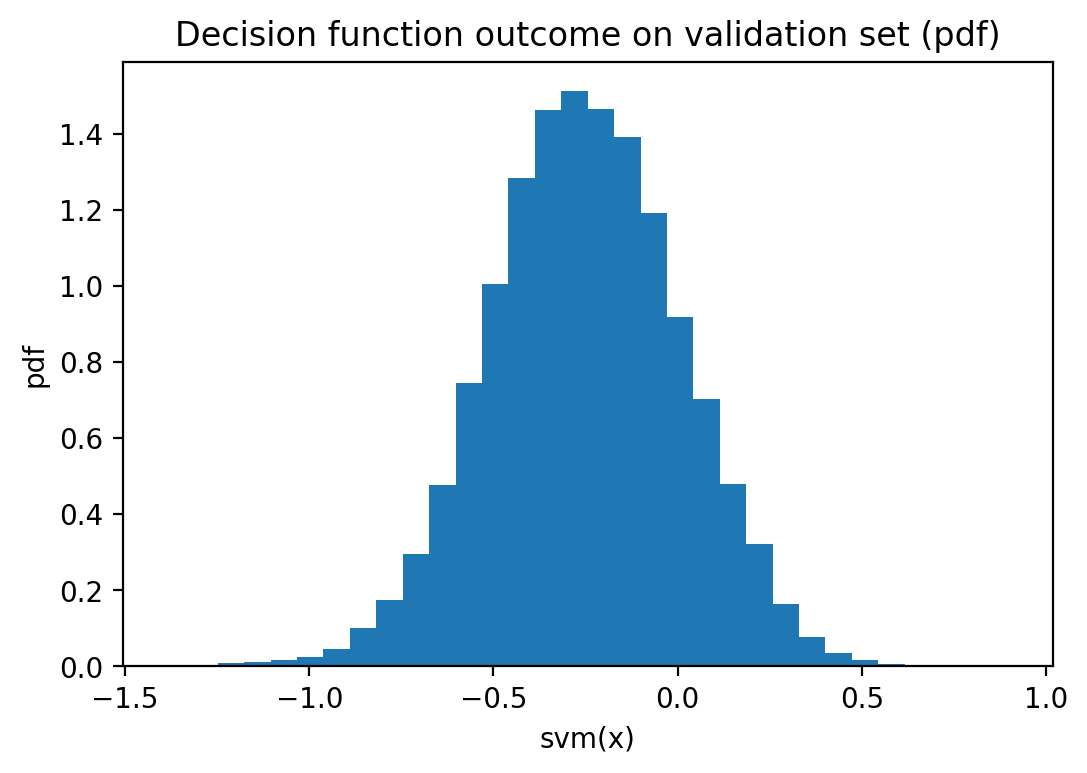

In [71]:
print(min(aggregate))
print(max(aggregate))
plt.figure()
plt.hist(aggregate, 32, normed=True)
plt.title('Decision function outcome on validation set (pdf)')
plt.xlabel('svm(x)')
plt.ylabel('pdf')
plt.show()

avgN=1 AUC: 0.640044300107
avgN=2 AUC: 0.674620757908
avgN=5 AUC: 0.693147846176
avgN=10 AUC: 0.701376995346
avgN=20 AUC: 0.702641283055
avgN=50 AUC: 0.703337303761
avgN=100 AUC: 0.704529799522


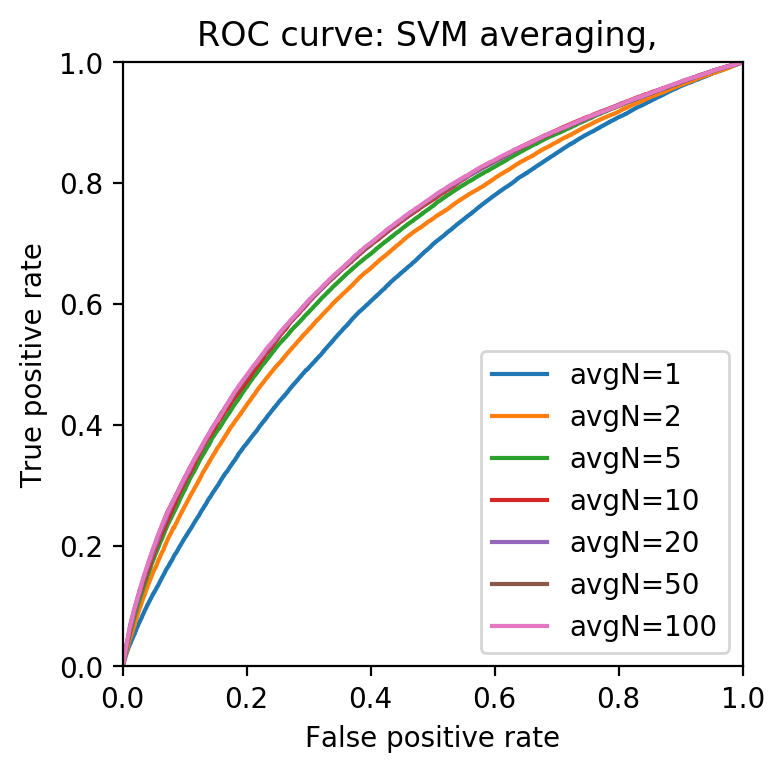

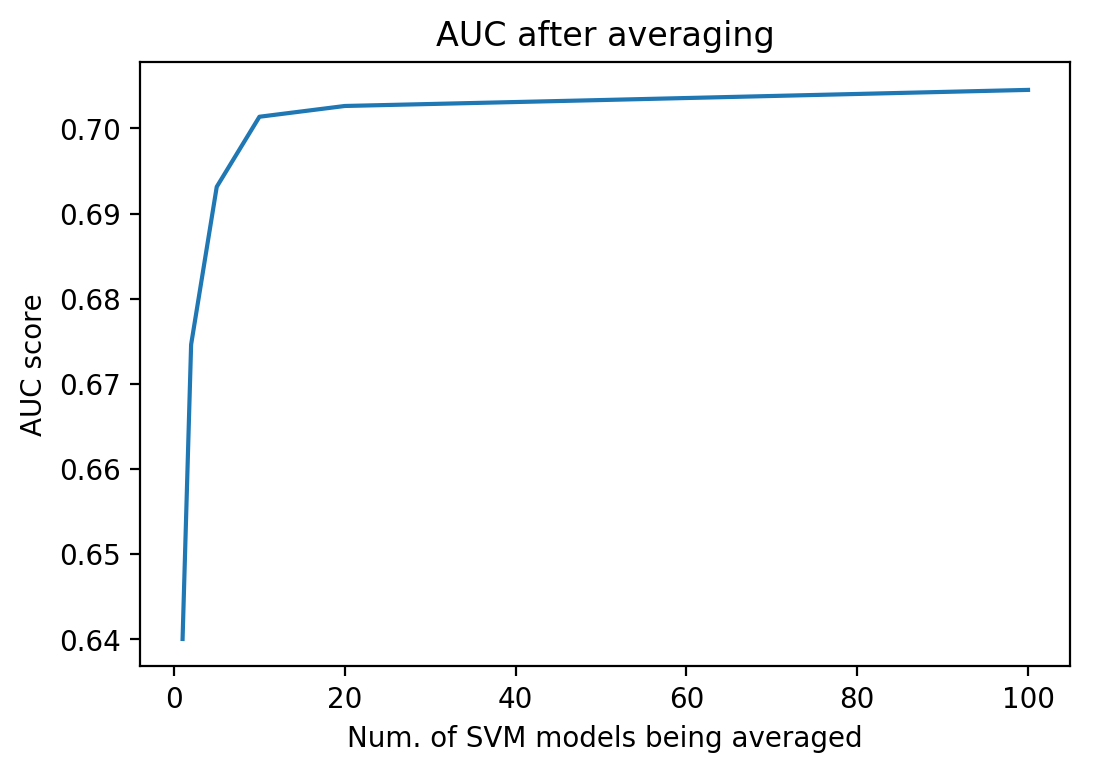

In [90]:
from sklearn.metrics import roc_curve, roc_auc_score

# Evaluate.
def evaluate(y, decision_fn, title):
    '''n - how many SVMs to average over'''
    
    fpr, tpr, thresholds = roc_curve(y_valid, decision_fn)
    auc = roc_auc_score(y, decision_fn)

    print(title + ' AUC: {0}'.format(auc))

    plt.plot(fpr, tpr, label=title)
    return auc
    

plt.figure(figsize=(4,4))
plt.title('ROC curve: SVM averaging, ')
aucs = []
ns = [1, 2, 5, 10, 20, 50, 100]
for n in ns:
    # n = how many SVMs to average over
    decision_fn = np.mean(decisions_array[:,:n], axis=1)
    aucs.append(evaluate(y_valid, decision_fn, 'avgN={0}'.format(n)))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend(loc='best')
plt.show()

plt.figure()
plt.plot(ns, aucs)
plt.title('AUC after averaging')
plt.xlabel('Num. of SVM models being averaged')
plt.ylabel('AUC score')
plt.show()

# SVMCeption

What if we feed the learned SVM results to another SVM? This time, one with a stronger kernel.

In [73]:
from sklearn.svm import SVC

In [74]:
decisions_train = np.stack([decision_one(svm, X_train) for svm in models], axis=1)
print(decisions_train.shape)

(242572, 100)


In [75]:
# Rescale the data
svmception_norm = Normalizer()
X_train_svm = svmception_norm.fit_transform(decisions_train)
X_valid_svm = svmception_norm.transform(decisions_array)
print(X_valid_svm.shape)

(161716, 100)


In [109]:
bag_num = 30
examples_per_bag = 5000
svmc_models = []

C=1.0

for i in range(bag_num):
    print('Model:', i)
    np.random.shuffle(indices)
    i_bag = indices[:examples_per_bag]
    X_bag = X_train_svm[i_bag]
    y_bag = [y_train[i] for i in i_bag]
    svm = SVC(C=C) # Try with just linear kernel
    svm.fit(X_bag, y_bag)
    svmc_models.append(svm)

Model: 0
Model: 1
Model: 2
Model: 3
Model: 4
Model: 5
Model: 6
Model: 7
Model: 8
Model: 9
Model: 10
Model: 11
Model: 12
Model: 13
Model: 14
Model: 15
Model: 16
Model: 17
Model: 18
Model: 19
Model: 20
Model: 21
Model: 22
Model: 23
Model: 24
Model: 25
Model: 26
Model: 27
Model: 28
Model: 29


In [111]:
trained_model = {
    '0_glove_normalizer': nrm,
    '1_bagged_linear_svms': models,
    '2_decision_fn_normalizer': svmception_norm,
    '3_bagged_rbf_svms': svmc_models
}

print(len(trained_model['1_bagged_linear_svms']))
print(len(trained_model['3_bagged_rbf_svms']))

100
30


In [112]:
import pickle
pickle.dump(trained_model, open('svmception02.pickle', 'wb'))

(2000, 100)
(2000, 100)
avgN=1 AUC: 0.710813899733
avgN=2 AUC: 0.711232321416
avgN=5 AUC: 0.711081432779
avgN=10 AUC: 0.712732646737
avgN=20 AUC: 0.712414817478
avgN=30 AUC: 0.712506848846
linearAvg(100) AUC: 0.706111738922


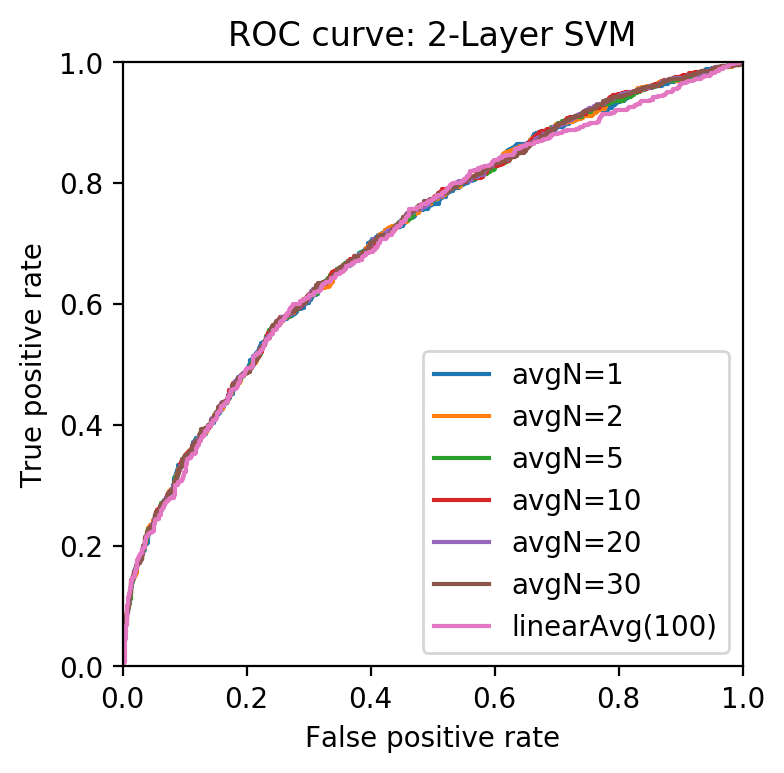

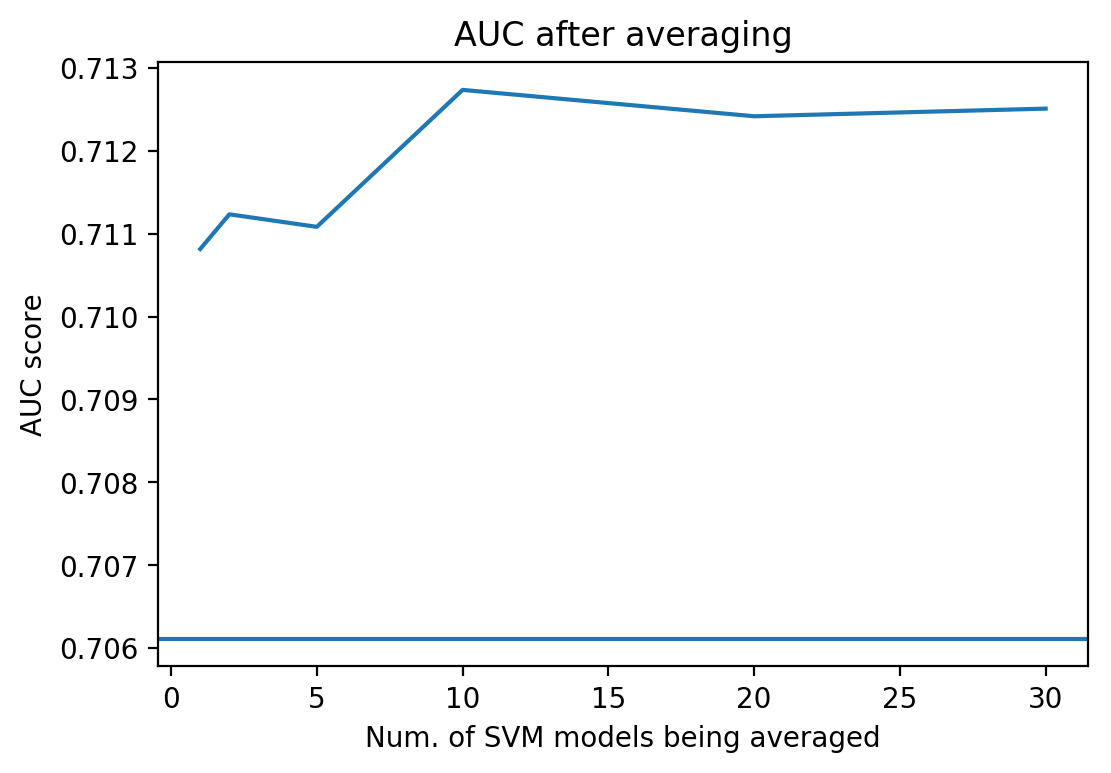

In [113]:
validation_ind = range(len(X_valid_svm))
np.random.shuffle(validation_ind)
N = 2000
valid_set = X_valid_svm[validation_ind[:N]]
decisions_base = decisions_array[validation_ind[:N]]
print(valid_set.shape)
print(decisions_base.shape)

svmc_decisions_array = np.stack([decision_one(svm, valid_set) for svm in svmc_models], axis=1)
svmc_aggregate = np.mean(svmc_decisions_array, axis=1)
y_valid_set_2 = [y_valid[i] for i in validation_ind[:N]]
def evaluate2(y, decision_fn, title):
    '''n - how many SVMs to average over'''
    
    fpr, tpr, thresholds = roc_curve(y, decision_fn)
    auc = roc_auc_score(y_valid_set_2, decision_fn)

    print(title + ' AUC: {0}'.format(auc))

    plt.plot(fpr, tpr, label=title)
    return auc

plt.figure(figsize=(4,4))
plt.title('ROC curve: 2-Layer SVM')
aucs = []
ns = [1, 2, 5, 10, 20, 30]
for n in ns:
    # n = how many SVMs to average over
    decision_fn = np.mean(svmc_decisions_array[:,:n], axis=1)
    aucs.append(evaluate2(y_valid_set_2, decision_fn, 'avgN={0}'.format(n)))
# Compare with best 1-layer model?
decision_fn_base = np.mean(decisions_base[:,:n], axis=1)
lin_auc = evaluate2(y_valid_set_2, decision_fn_base, 'linearAvg(100)')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend(loc='best')
plt.show()

plt.figure()
plt.plot(ns, aucs)
plt.title('AUC after averaging')
plt.xlabel('Num. of SVM models being averaged')
plt.axhline(y=lin_auc, label='Linear100')
plt.ylabel('AUC score')
plt.show()

It seems to help a *little bit*, but probably not really worth it for just a < 1% AUC increase. What's more interesting is we've hit an inflection point where the validation set performance has started decaying as I add models. So I'm thinking this is the limit of what we can do using this approach.

Here's the second plot with better coloring:

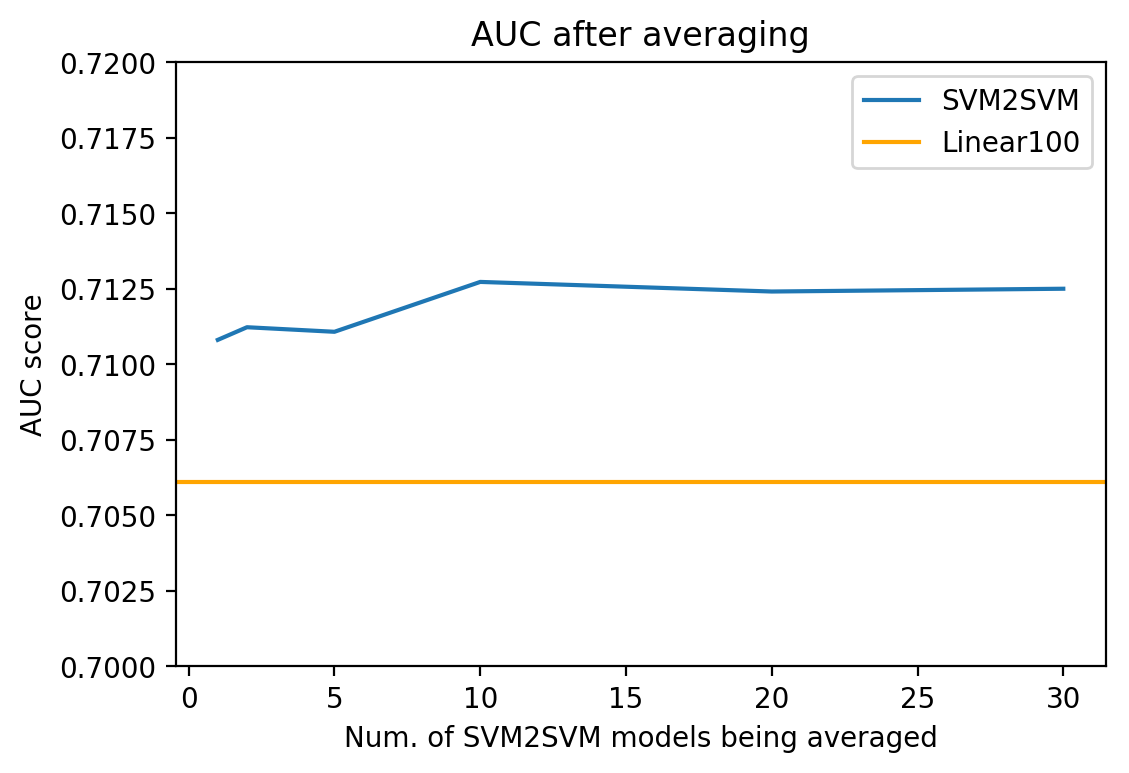

In [117]:
plt.figure()
plt.plot(ns, aucs, label='SVM2SVM')
plt.title('AUC after averaging')
plt.xlabel('Num. of SVM2SVM models being averaged')
plt.axhline(y=lin_auc, label='Linear100', color='orange')
plt.ylabel('AUC score')
plt.legend(loc='best')
plt.ylim(0.7, 0.72)
plt.show()

# Summary

1. Bagging works.
1. Layering SVMs on top of another didn't work as well as expected, even with different kernels. It did help a little.